# Recovering rotation periods in simulated LSST data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gatspy.periodic import LombScargle
import sys
%matplotlib inline
from toy_simulator import simulate_LSST
from trilegal_models import random_stars
import simple_gyro as sg
import pandas as pd

Randomly select targets from a TRILEGAL output.

In [3]:
fname = "output574523944248.dat"
N = 100
logAges, bvs, logTeff, rmag = random_stars(fname, N)
teff = 10**logTeff

Calculate periods from ages and colours for cool stars

In [4]:
m = bvs > .4  # select only cool stars
cool_ages = 10**logAges[m] * 1e-9
cool_ps = sg.period(cool_ages, bvs[m])
cool_teffs = teff[m]
cool_rmags = rmag[m]

Draw from a sum of two Gaussians (modelled in another notebook) that describes the period distribution for hot stars. Approximations: I have lumped all stars with colour < 0.4 in together AND I actually used teff = 6250, not B-V = 0.4 in the other notebook.

In [5]:
hot_ages = 10**logAges[~m] * 1e-9 # select hot stars
hot_teffs = teff[~m]
hot_rmags = rmag[~m]

# copy parameters for two Gaussians from hot_stars ipython notebook
A1, A2, mu1, mu2, sig1, sig2 = 254.11651209, 49.8149765, 3.00751724, 3.73399554, 2.26525979, 8.31739725

hot_ps = np.zeros_like(hot_ages)
hot_ps1 = np.random.randn(int(len(hot_ages)*(1 - A2/A1)))*sig1 + mu1  # mode 1
hot_ps2 = np.random.randn(int(len(hot_ages)*(A2/A1)))*sig2 + mu2  # mode 2
hot_ps[:len(hot_ps1)] = hot_ps1
hot_ps[len(hot_ps1):len(hot_ps2)] = hot_ps2
tot = len(hot_ps1) + len(hot_ps2)
hot_ps[tot:] = np.random.randn(len(hot_ps)-tot)*sig2 + mu2  # make up the total number of Ps

# combine the modes
age = np.concatenate((cool_ages, hot_ages))
ps = np.concatenate((cool_ps, hot_ps))
teff = np.concatenate((cool_teffs, hot_teffs))
rmag = np.concatenate((cool_rmags, hot_rmags))

Make histograms of the ages and periods

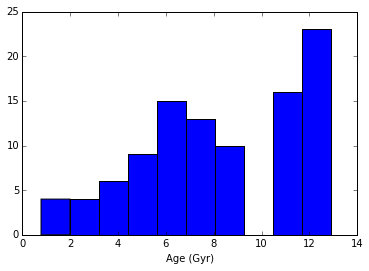

In [6]:
plt.hist(age)
plt.xlabel("Age (Gyr)")

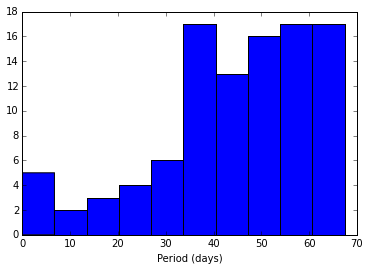

In [7]:
plt.hist(ps)
plt.xlabel("Period (days)")

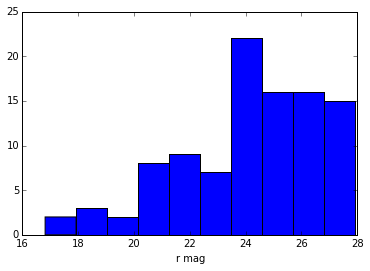

In [8]:
plt.hist(rmag)
plt.xlabel("r mag")

In [9]:
## Arrays of random (log-normal) periods and (uniform) amplitudes.
#min_period, max_period = 1, 100  # days
#ps = np.exp(np.random.uniform(np.log(min_period), np.log(max_period), N))  # periods
#amps = np.random.uniform(10, 300, N)  # ppm

Use Derek's results to calculate amplitudes

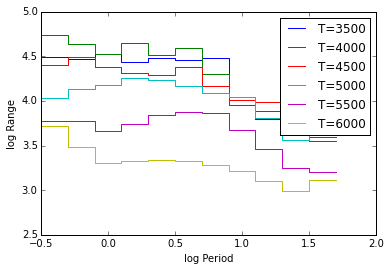

In [10]:
# Column headings: log10P, log10R, stdR, Nbin
teff_bins = [3500, 4000, 4500, 5000, 5500, 6000]
d35 = pd.read_csv("data/rot_v_act3500.txt")
d40 = pd.read_csv("data/rot_v_act4000.txt")
d45 = pd.read_csv("data/rot_v_act4500.txt")
d50 = pd.read_csv("data/rot_v_act5000.txt")
d55 = pd.read_csv("data/rot_v_act5500.txt")
d60 = pd.read_csv("data/rot_v_act6000.txt")

plt.step(d35["log10P"], d35["log10R"], label="T=3500")
plt.step(d40["log10P"], d40["log10R"], label="T=4000")
plt.step(d45["log10P"], d45["log10R"], label="T=4500")
plt.step(d50["log10P"], d50["log10R"], label="T=5000")
plt.step(d55["log10P"], d55["log10R"], label="T=5500")
plt.step(d60["log10P"], d60["log10R"], label="T=6000")
plt.legend()
plt.xlabel("log Period")
plt.ylabel("log Range")

Assign amplitudes

In [10]:
def find_nearest (array, value):
    """
    Match a period to a bin.
    array: array of bin heights.
    value: the period of the star.
    Returns the value and index of the bin.
    """
    m = np.abs(array-value) == np.abs(array-value).min()
    return array[m], m

def assign_amps(ps, log10P, log10R, stdR):
    """
    Take periods and bin values and return an array of amplitudes.
    """
    npi = np.array([find_nearest(10**log10P, p) for p in ps])  # match periods to bins
    nearest_ps, inds = npi[:, 0], npi[:, 1]
    log_ranges = np.array([log10R[i] for i in inds])[:, 0]  # array of ranges for each *
    std_ranges = np.array([stdR[i] for i in inds])[:, 0]  # array of stdevs in range for each *
    return np.random.randn(len(ps))*std_ranges + log_ranges  # draw amps from Gaussians

def make_arrays(data, temp_bin):
    """
    Amplitude arrays for each temperature bin
    """
    P, R, std = np.array(data["log10P"]), np.array(data["log10R"]), np.array(data["stdR"])
    if temp_bin == 3500:
        m = teff < 3750
    elif temp_bin == 6000:
        m = teff > 6000
    else:
        m = (temp_bin - 250 < teff) * (teff < temp_bin + 250)
    periods, teffs, rmags = ps[m], teff[m], rmag[m]
    amplitudes = assign_amps(periods, P, R, std)
    return periods, amplitudes, teffs, rmags

def LSST_sig(m):
    """
    Approximate the noise in figure 2 of arxiv:1603.06638 from the apparent r-mag.
    Returns the noise in magnitudes and ppm.
    """
    if m < 19:
        return .005
    mags = np.array([19, 20, 21, 22, 23, 24, 25])
    sigs = np.array([.005, .007, .01, .02, .03, .1, .2])
    return sigs[np.abs(mags - m) == np.abs(mags-m).min()][0]

pers, logamps, teffs, rmags = np.concatenate((make_arrays(d35, 3500), make_arrays(d40, 4000), 
                                              make_arrays(d45, 4500), make_arrays(d50, 5000), 
                                              make_arrays(d55, 5500), make_arrays(d60, 6000)), axis=1)
amps = 10**logamps  # parts per million
noise = LSST_sig(rmag[0])
noises_mag = np.array([LSST_sig(mag) for mag in rmags])
noises_ppm = (1 - 10**(-noises_mag/2.5)) * 1e6

Simulate light curves

In [11]:
%%capture
# amps = np.random.uniform(10, 300, N)  # ppm
path = "simulations"  # where to save the lcs
[simulate_LSST(i, pers[i], amps[i], path, noises_ppm[i]) for i in range(len(pers))]  # simulations

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [12]:
# save the true values
ids = np.arange(len(pers))
data = np.vstack((ids, pers, amps))
np.savetxt("{0}/truth.txt".format(path), data.T)

Load and plot an example light curve

<Container object of 3 artists>

/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


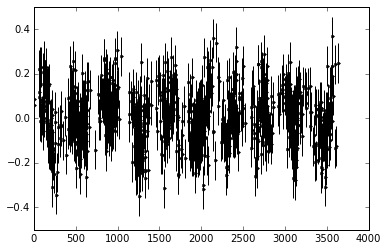

In [13]:
id = 0
sid = str(int(id)).zfill(4)
path = "results"  # where to save results
x, y, yerr = np.genfromtxt("simulations/{0}.txt".format(sid)).T  # load a fake light curve
plt.errorbar(x, y, yerr=yerr, fmt="k.", capsize=0)

Compute a periodogram

18.8728728729 18.1061220578


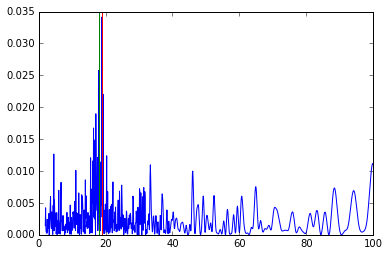

In [14]:
ps = np.linspace(2, 100, 1000)  # the period array (in days)
model = LombScargle().fit(x, y, yerr)
pgram = model.periodogram(ps)

# find peaks
peaks = np.array([i for i in range(1, len(ps)-1) if pgram[i-1] < pgram[i] and pgram[i+1] < pgram[i]])
if len(peaks):
    period = ps[pgram==max(pgram[peaks])][0]
else: period = 0

plt.plot(ps, pgram)  # plot the pgram
plt.axvline(period, color="r")  # plot the position of the highest peak

# load and plot the truth
ids, true_ps, true_as = np.genfromtxt("simulations/truth.txt").T
plt.axvline(true_ps[id], color="g")  # plot the position of the highest peak

print(period, true_ps[id])

Now compute LS pgrams for a set of LSST light curves and save the highest peak .

In [15]:
ids = np.arange(len(pers))
periods = np.zeros_like(ids)
for i, id in enumerate(ids):
    sid = str(int(id)).zfill(4)
    x, y, yerr = np.genfromtxt("simulations/{0}.txt".format(sid)).T  # load a fake light curve

    model = LombScargle().fit(x, y, yerr)  # compute pgram
    pgram = model.periodogram(ps)

    # find peaks
    peaks = np.array([i for i in range(1, len(ps)-1) if pgram[i-1] < pgram[i] and pgram[i+1] < pgram[i]])
    if len(peaks):
        period = ps[pgram==max(pgram[peaks])][0]
    else: period = 0

    periods[i] = period

Save the data

In [16]:
data = np.vstack((true_ps, periods, teffs, rmags, true_as, noises_ppm))
np.savetxt("rotation_results{0}.txt".format(fname), data.T)

Plot the recovered periods vs the true periods.

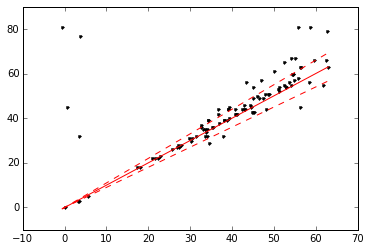

In [17]:
plt.plot(true_ps, periods, "k.")
xs = np.linspace(min(true_ps), max(true_ps), 100)
plt.plot(xs, xs, "r")

tau = .1  # the recovery must be within a factor of *threshold* of the truth
plt.plot(xs, xs-tau*xs, "r--")
plt.plot(xs, xs+tau*xs, "r--")

Decide whether the recovery was successful or not

99 injected 66 recovered
66.66666666666666 percent success


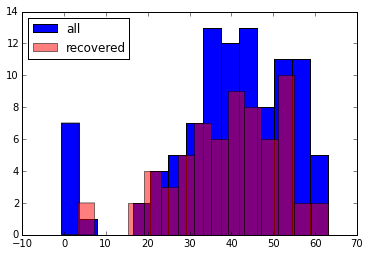

In [18]:
m = (true_ps - tau*true_ps < periods) * (periods < true_ps + tau*true_ps)

plt.hist(true_ps, 15, color="b", label="all")
plt.hist(true_ps[m], 15, color="r", alpha=.5, label="recovered")
plt.legend(loc="best")
print(len(true_ps), "injected", len(true_ps[m]), "recovered")
print(len(true_ps[m])/len(true_ps)*100, "percent success")